# Deep Vision
___

**Author** : Aman Hussain  
**Email** : aman@amandavinci.me  
**Description** : Classifying images of dogs and cats by finetuning the VGG16 model

## Import Libraries

#### Scientific Computing Stack

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Custom Packages

In [2]:
import os, json

from helper import utils
from helper.utils import plots

from helper import vgg16
from helper.vgg16 import Vgg16

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/aman/anaconda3/envs/fastai/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/home/aman/anaconda3/envs/fastai/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/home/aman/anaconda3/envs/fastai/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 60, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 634, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 584, in pygpu.gpuarray.pygpu_init
  File "pygpu/gpuarray.pyx", line 1057, in pygpu.gpuarray.GpuContext.__cinit__
pygpu.gpuarray.GpuArrayException: b'cuInit: CUDA_ERROR_UNKNOWN: unknown error'
Using TensorFlow backend.


## Declaring paths & global parameters

The path to the dataset is defined here. It will point to the sample folder which contains lesser number of images for quick and iterative training on the local machine. For the final training, on the cloud we must change the path to the one commented out below.

In [3]:
path = '../data/dogscats/sample/'
# path = '../data/dogscats/'

The default batchsize for training and validation purposes

In [4]:
batchsize = 8

## Data Exploration

Instantiating the VGG16 class which implements the required utility methods

In [5]:
vgg = Vgg16()

Getting the training and validation batches

In [6]:
batches = vgg.get_batches(path+'train', batch_size=batchsize)
val_batches = vgg.get_batches(path+'valid', batch_size=batchsize)

Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


Visualizing the images, only if we are exploring the samples

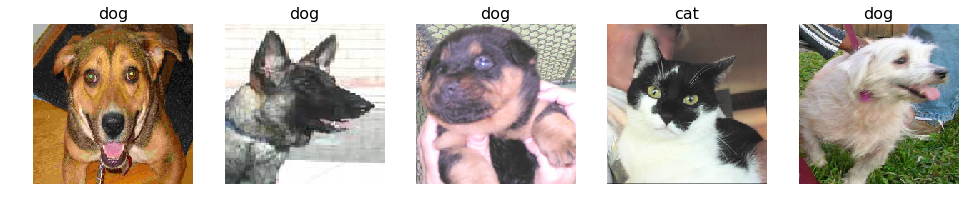

In [7]:
if path == '../data/dogscats/sample/':
    imgs, labels = next(batches)
    val_imgs, val_labels = next(val_batches)
    labels = ['dog' if i[0]==0 else 'cat' for i in labels]
    val_labels = ['dog' if i[0]==0 else 'cat' for i in val_labels]
    plots(val_imgs[:5], figsize=(20,10), titles=val_labels)

## Finetuning

In [8]:
vgg.finetune(batches)

In [9]:
%%time
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
50/50 [==============================] - 156s - loss: 1.9047 - acc: 0.5600 - val_loss: 2.5661 - val_acc: 0.5000
CPU times: user 9min 4s, sys: 12.8 s, total: 9min 17s
Wall time: 2min 37s


## Model Testing

Due to the quirkiness of the ImageDataGenerator.flow_from_directory() used by vgg.get_batches(), we have to make a sub directory under test directory by the name 'subdir_for_keras_ImageDataGenerator'.

In [10]:
batch_size = len(os.listdir(path+'test'+'/subdir_for_keras_ImageDataGenerator'))

Keras ImageDataGenerator does not return the filenames and loads them in the same order as os.listdir() returns. Here, we extract the filenames which will serve as the indexes.

In [11]:
img_index = os.listdir(path+'test'+'/subdir_for_keras_ImageDataGenerator')
img_index = [os.path.splitext(file)[0] for file in img_index]

With the class_mode set to None, it will return only the batch of images without labels

In [12]:
testbatch = vgg.get_batches(path+'test', shuffle=False, batch_size=batch_size, class_mode=None)

Found 10 images belonging to 1 classes.


In [13]:
test_imgs = next(testbatch) 

Manually verifying the predicitons

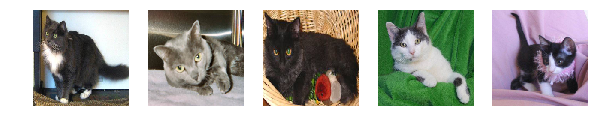

In [14]:
plots(test_imgs[:5])

In [15]:
probab, prediction, prediction_labels = vgg.predict(test_imgs[:5], details = True)
print(prediction_labels, probab, prediction)

['cats', 'cats', 'cats', 'cats', 'cats'] [ 0.9989  0.994   0.9866  0.9999  0.9999] [0 0 0 0 0]


Here, we make the predictions using our trained model

In [16]:
%%time
probab, prediction, prediction_labels = vgg.predict(test_imgs, details = True)

CPU times: user 1min 26s, sys: 1.88 s, total: 1min 28s
Wall time: 25 s


## Results

Preparing to save the predictions as submissions to the Kaggle competetion

In [17]:
np.save(path+'submissions/index', img_index)
np.save(path+'submissions/probab', probab)
np.save(path+'submissions/prediction', prediction)
np.save(path+'submissions/prediction_labels', prediction_labels)

Save the trained model

In [18]:
# vgg.model.save("../models/vgg_dogsVScats.h5")

In [19]:
for predicted, index in enumerate(prediction):
    # When a cat is predicted, get the complimentary value
    if predicted == 0:
        probab[index] = 1 - probab[index]

In [20]:
img_index.insert(0, 'id')

labels_pred = [str(label) for label in prediction]
labels_pred.insert(0, 'label')

labels_prob = [str(label) for label in probab]
labels_prob.insert(0, 'label')

In [21]:
submission_array_pred = np.vstack((img_index, labels_pred)).T.astype('str')
submission_array_prob = np.vstack((img_index, labels_prob)).T.astype('str')

Saving the array as a CSV

In [22]:
np.savetxt(path+'submissions/submission_pred.csv', submission_array_pred, delimiter=",", fmt='%1s')
np.savetxt(path+'submissions/submission_prob.csv', submission_array_prob, delimiter=",", fmt='%1s')

___